# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

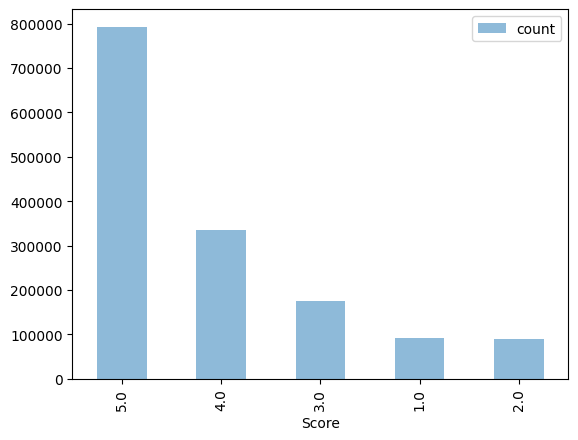


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
def add_features_to(df):
    # Feature extraction


    if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
        df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, 1)
        df['Helpfulness'] = df['Helpfulness'].fillna(0)


    if 'Time' in df.columns:
        df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year
        df['Month'] = pd.to_datetime(df['Time'], unit='s').dt.month


        df['Is_Recent'] = (df['Year'] > df['Year'].median()).astype(int)


    if 'Text' in df.columns:
        df['TextLength'] = df['Text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)


    if 'Summary' in df.columns:
        df['SummaryWordCount'] = df['Summary'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)


    if 'Helpfulness' in df.columns:
        df['Helpfulness_Bin'] = pd.cut(df['Helpfulness'], bins=[-1, 0.2, 0.5, 1], labels=['Low', 'Medium', 'High'])
        df = pd.get_dummies(df, columns=['Helpfulness_Bin'])


    if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
        df['Helpfulness_Diff'] = df['HelpfulnessNumerator'] - df['HelpfulnessDenominator']

    return df



if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")

else:

    X_train = add_features_to(trainingSet)
    X_submission = add_features_to(testingSet)


    X_submission = pd.merge(X_train, X_submission, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})


    X_train = X_train[X_train['Score'].notnull()]


    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)


# Sample + Split into training and testing set

In [4]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [5]:
# Ensure feature engineering has been applied
X_train = add_features_to(X_train)
X_test = add_features_to(X_test)
X_submission = add_features_to(X_submission)


features = ['Helpfulness', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'TextLength', 'SummaryWordCount',
            'Helpfulness_Bin_Low', 'Helpfulness_Bin_Medium', 'Helpfulness_Bin_High',
            'Year', 'Month', 'Is_Recent', 'Helpfulness_Diff']


X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]



# Model Creation

In [6]:
# Initialize Random Forest Model with optimizations
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

# Fit model on a sample of the data (optional for speed)
X_train_sample = X_train_select.sample(frac=0.3, random_state=42)
Y_train_sample = Y_train.loc[X_train_sample.index]
rf_model.fit(X_train_sample, Y_train_sample)

# Predict and evaluate on the test set
Y_test_predictions = rf_model.predict(X_test_select)
print("Optimized Random Forest accuracy on testing set:", accuracy_score(Y_test, Y_test_predictions))


Optimized Random Forest accuracy on testing set: 0.5534637094168084


# Model Evaluation

Accuracy on testing set =  0.5534637094168084


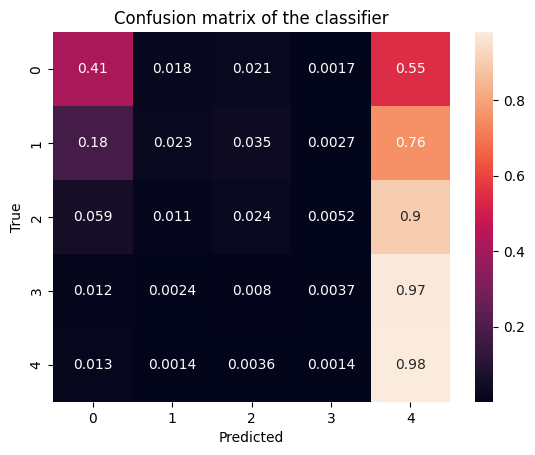

In [7]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [ ]:
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)